In [1]:
from comet_ml import Experiment

In [ ]:
with open("api_key.txt", "r") as f:
    api_key = json.load(f)

In [3]:
hyper_params = {
    "learning_rate": 0.0001
}

experiment = Experiment(project_name="gun", api_key=api_key['api_key'])
experiment.log_parameters(hyper_params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/michalmiotk/gun/2411205bc28e45dbaebb3f3dd413cbf0



In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("weapons", {}, "/Pobrane/trainval.json", "/Pobrane/images")
register_coco_instances("weapons_test", {}, "/Pobrane/trainval.json", "/Pobrane/images")
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [5]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [6]:
dataset_dicts = DatasetCatalog.get("weapons")
glock_metadata = MetadataCatalog.get("weapons")

In [7]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/images/More-weapons-1/table_48621_original.png


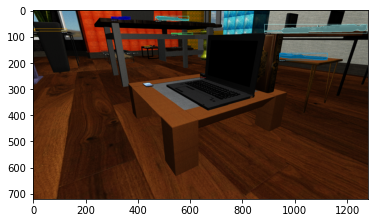

In [8]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glock_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [9]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [10]:
from datetime import datetime
import os

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons"#_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.MODEL.BACKBONE.FREEZE_AT=2
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR = hyper_params['learning_rate'] # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 500_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS = 10_000
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (100_000, 200_000, 300_000, 400_000, 500_000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 100_000 
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [12]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [ ]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[11/03 11:44:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/03 11:44:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/03 11:44:14 d2.data.datasets.coco]: Loading /Pobrane/trainval.json takes 11.60 seconds.
[11/03 11:44:14 d2.data.datasets.coco]: Loaded 69988 images in COCO format from /Pobrane/trainval.json
[11/03 11:44:17 d2.data.build]: Removed 0 images with no usable annotations. 69988 images left.
[11/03 11:44:19 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   weapon   | 226296       |   person   | 37545        |
|            |              |            |              |
|   total    | 263841       |            |              |
[11/03 11:44:19 d2.data.common]: Serializing 69988 elements to byte tensors and concatenating them all ...
[11/03 11:44:20 d2

model_final_f10217.pkl: 178MB [00:31, 5.66MB/s]                              


[11/03 11:44:53 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  ite

[11/03 11:45:01 d2.utils.events]:  eta: 2 days, 3:43:20  iter: 19  total_loss: 1.882  loss_cls: 0.6526  loss_box_reg: 0.1476  loss_mask: 0.4846  loss_rpn_cls: 0.2367  loss_rpn_loc: 0.3711  time: 0.3686  data_time: 0.0212  lr: 2.8981e-07  max_mem: 2680M
[11/03 11:45:09 d2.utils.events]:  eta: 2 days, 4:40:21  iter: 39  total_loss: 2.057  loss_cls: 0.8895  loss_box_reg: 0.1501  loss_mask: 0.463  loss_rpn_cls: 0.2173  loss_rpn_loc: 0.1324  time: 0.3802  data_time: 0.0136  lr: 4.8961e-07  max_mem: 2718M
[11/03 11:45:17 d2.utils.events]:  eta: 2 days, 4:52:20  iter: 59  total_loss: 2.204  loss_cls: 0.662  loss_box_reg: 0.1183  loss_mask: 0.5116  loss_rpn_cls: 0.3985  loss_rpn_loc: 0.2235  time: 0.3820  data_time: 0.0035  lr: 6.8941e-07  max_mem: 2718M
[11/03 11:45:24 d2.utils.events]:  eta: 2 days, 4:26:48  iter: 79  total_loss: 1.998  loss_cls: 0.7514  loss_box_reg: 0.1303  loss_mask: 0.4394  loss_rpn_cls: 0.3935  loss_rpn_loc: 0.1616  time: 0.3752  data_time: 0.0034  lr: 8.8921e-07  max_m

[11/03 11:48:59 d2.utils.events]:  eta: 2 days, 3:33:49  iter: 659  total_loss: 1.228  loss_cls: 0.4331  loss_box_reg: 0.1241  loss_mask: 0.3525  loss_rpn_cls: 0.04872  loss_rpn_loc: 0.1228  time: 0.3699  data_time: 0.0029  lr: 6.6834e-06  max_mem: 2718M
[11/03 11:49:05 d2.utils.events]:  eta: 2 days, 3:29:17  iter: 679  total_loss: 0.9724  loss_cls: 0.4208  loss_box_reg: 0.1075  loss_mask: 0.3084  loss_rpn_cls: 0.04776  loss_rpn_loc: 0.04805  time: 0.3690  data_time: 0.0032  lr: 6.8832e-06  max_mem: 2718M
[11/03 11:49:12 d2.utils.events]:  eta: 2 days, 3:23:54  iter: 699  total_loss: 1.081  loss_cls: 0.4433  loss_box_reg: 0.1253  loss_mask: 0.304  loss_rpn_cls: 0.08079  loss_rpn_loc: 0.1006  time: 0.3682  data_time: 0.0036  lr: 7.083e-06  max_mem: 2718M
[11/03 11:49:19 d2.utils.events]:  eta: 2 days, 3:13:59  iter: 719  total_loss: 1.172  loss_cls: 0.4812  loss_box_reg: 0.1287  loss_mask: 0.3596  loss_rpn_cls: 0.04655  loss_rpn_loc: 0.1326  time: 0.3674  data_time: 0.0037  lr: 7.2828e

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("weapons")
glock_test_metadata = MetadataCatalog.get("weapons")

In [ ]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())